   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 8.7 MB/s eta 0:00:00
Non-private baseline accuracy: 0.9580
eps=0.050  => DP accuracy: 0.3986
eps=0.100  => DP accuracy: 0.3497
eps=0.200  => DP accuracy: 0.8182
eps=0.500  => DP accuracy: 0.8881
eps=1.000  => DP accuracy: 0.6364
eps=2.000  => DP accuracy: 0.7063


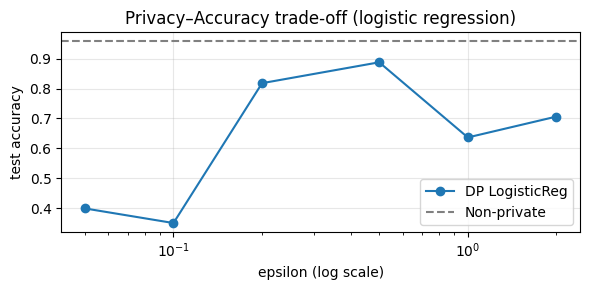

In [ ]:
!pip install -q diffprivlib matplotlib scikit-learn

import numpy as np, pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as SkLogReg
from diffprivlib.models import LogisticRegression as DPLogReg
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

np.random.seed(0)

# --- Load & prep data ---
X, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X)   # scale features (good practice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# --- Baseline (non-private) ---
base = SkLogReg(max_iter=200, solver="lbfgs")
base.fit(X_train, y_train)
base_acc = accuracy_score(y_test, base.predict(X_test))
print(f"Non-private baseline accuracy: {base_acc:.4f}")

# Choose epsilons to try
eps_list = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]

results = []
# data_norm: the DP model needs a bound on row L2 norm.
# For demo we use the max norm from training data (in practice choose independently).
data_norm = np.max(np.linalg.norm(X_train, axis=1))

for eps in eps_list:
    dp = DPLogReg(epsilon=eps, data_norm=float(data_norm), max_iter=200)
    dp.fit(X_train, y_train)
    acc = accuracy_score(y_test, dp.predict(X_test))
    print(f"eps={eps:.3f}  => DP accuracy: {acc:.4f}")
    results.append((eps, acc))

# --- Plot ---
eps_vals, accs = zip(*results)
plt.figure(figsize=(6,3))
plt.plot(eps_vals, accs, marker='o', label='DP LogisticReg')
plt.axhline(base_acc, color='gray', linestyle='--', label='Non-private')
plt.xscale('log')
plt.xlabel('epsilon (log scale)')
plt.ylabel('test accuracy')
plt.title('Privacy–Accuracy trade-off (logistic regression)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
